###Importing Packages

In [1]:
import numpy as np 
import pandas as pd 
data_paths = {}
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

### Installing Pyspark

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Using Spark in Python

In [3]:
from pyspark import SparkContext, SparkConf
sc = SparkContext('local')
print(sc.version)

3.3.2


### Using Spark DataFrames

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
print(spark)

### Viewing tables

In [5]:
print(spark.catalog.listTables())

[]


Spark

In [6]:
pd_temp = pd.DataFrame(np.random.random(10))

spark_temp = spark.createDataFrame(pd_temp)

print(spark.catalog.listTables())

spark_temp.createOrReplaceTempView('temp')

print(spark.catalog.listTables())

[]
[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [7]:
airports = spark.read.csv('airports.csv', header = True)

airports.show(10)

+---------+--------------------+-------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|    USA|40.65236| -75.44040|
|      ABI|Abilene Regional ...|      Abilene|   TX|    USA|32.41132| -99.68190|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|       Albany|   GA|    USA|31.53552| -84.19447|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|    USA|41.25305| -70.06018|
|      ACT|Waco Regional Air...|         Waco|   TX|    USA|31.61129| -97.23052|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|    USA|40.97812|-124.10862|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|    USA|39.45758| -74.57717|
|      ADK|        Adak Airp

In [8]:
flights = spark.read.csv('flights.csv', header = True)

print((flights.count(), len(flights.columns)))

print(spark.catalog.listTables())

flights.createOrReplaceTempView('flights')

print(spark.catalog.listTables())

(738906, 31)
[Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]
[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


In [9]:
print(flights.columns)

['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


In [10]:
query = "SELECT AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE FROM flights LIMIT 5"

flights5 = spark.sql(query)

flights5.show()

+-------+-------------+-----------+--------------+-------------------+-------------------+
|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|
+-------+-------------+-----------+--------------+-------------------+-------------------+
|     AS|           98|     N407AS|           ANC|                SEA|               0005|
|     AA|         2336|     N3KUAA|           LAX|                PBI|               0010|
|     US|          840|     N171US|           SFO|                CLT|               0020|
|     AA|          258|     N3HYAA|           LAX|                MIA|               0020|
|     AS|          135|     N527AS|           SEA|                ANC|               0025|
+-------+-------------+-----------+--------------+-------------------+-------------------+



In [11]:
query = "SELECT ORIGIN_AIRPORT, DESTINATION_AIRPORT, COUNT(*) as N FROM flights GROUP BY ORIGIN_AIRPORT, DESTINATION_AIRPORT"

flight_counts = spark.sql(query)

pd_counts = flight_counts.toPandas()

print(pd_counts.head())

  ORIGIN_AIRPORT DESTINATION_AIRPORT    N
0            BQN                 MCO   61
1            PHL                 MCO  685
2            MCI                 IAH  226
3            SPI                 ORD  146
4            SNA                 PHX  555


### Creating columns

In [12]:
flights = spark.table("flights")

flights = flights.withColumn('duration_hrs', flights.AIR_TIME/60.)

flights.select('duration_hrs').show(10)

+------------------+
|      duration_hrs|
+------------------+
| 2.816666666666667|
| 4.383333333333334|
| 4.433333333333334|
|               4.3|
| 3.316666666666667|
| 3.433333333333333|
| 2.566666666666667|
|               3.8|
|2.8833333333333333|
|               3.1|
+------------------+
only showing top 10 rows



### SQL

In [13]:
long_flights1 = flights.filter("DISTANCE > 1000")

long_flights2 = flights.filter(flights.DISTANCE > 1000)

In [14]:
selected1 = flights.select('TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',)

temp = flights.select(flights.ORIGIN_AIRPORT, flights.DESTINATION_AIRPORT, flights.AIRLINE)

temp.show()

+--------------+-------------------+-------+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|AIRLINE|
+--------------+-------------------+-------+
|           ANC|                SEA|     AS|
|           LAX|                PBI|     AA|
|           SFO|                CLT|     US|
|           LAX|                MIA|     AA|
|           SEA|                ANC|     AS|
|           SFO|                MSP|     DL|
|           LAS|                MSP|     NK|
|           LAX|                CLT|     US|
|           SFO|                DFW|     AA|
|           LAS|                ATL|     DL|
|           DEN|                ATL|     DL|
|           LAS|                MIA|     AA|
|           LAX|                MSP|     DL|
|           SLC|                ATL|     DL|
|           SEA|                MSP|     DL|
|           ANC|                SEA|     AS|
|           ANC|                SEA|     DL|
|           SFO|                IAH|     UA|
|           ANC|                PDX|     AS|
|         

In [15]:
filterA = flights.ORIGIN_AIRPORT == "SEA"

filterB = flights.DESTINATION_AIRPORT == "PDX"

selected2 = temp.filter(filterA).filter(filterB)

In [16]:
avg_speed = (flights.DISTANCE/(flights.AIR_TIME/60)).alias("avg_speed")

speed1 = flights.select('TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', avg_speed)

speed2 = flights.selectExpr('TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', "DISTANCE/(AIR_TIME/60) as avg_speed")

In [17]:
flights = flights.withColumn("MONTH", flights.MONTH.cast("integer"))
flights = flights.withColumn("DAY_OF_WEEK", flights.DAY_OF_WEEK.cast("integer"))
flights = flights.withColumn("AIR_TIME", flights.AIR_TIME.cast("integer"))
flights = flights.withColumn("DISTANCE", flights.DISTANCE.cast("double"))
flights = flights.withColumn("ARRIVAL_DELAY", flights.ARRIVAL_DELAY.cast("integer"))

In [18]:
flights.filter(flights.ORIGIN_AIRPORT == 'PDX').groupBy().min('DISTANCE').show()

flights.filter(flights.ORIGIN_AIRPORT == 'SEA').groupBy().max('AIR_TIME').show()

+-------------+
|min(DISTANCE)|
+-------------+
|        129.0|
+-------------+

+-------------+
|max(AIR_TIME)|
+-------------+
|          411|
+-------------+



In [19]:
by_plane = flights.groupBy("TAIL_NUMBER")

by_plane.count().show(10)

by_origin = flights.groupBy("ORIGIN_AIRPORT")

by_origin.avg("AIR_TIME").show(10)

+-----------+-----+
|TAIL_NUMBER|count|
+-----------+-----+
|     N38451|  122|
|     N567AA|  203|
|     N623NK|  218|
|     N442AS|  151|
|     N902DE|  200|
|     N4YUAA|  154|
|     N466SW|  315|
|     N516UA|   98|
|     N866AS|  350|
|     N499AA|  172|
+-----------+-----+
only showing top 10 rows

+--------------+------------------+
|ORIGIN_AIRPORT|     avg(AIR_TIME)|
+--------------+------------------+
|           BGM|             67.72|
|           PSE|187.33962264150944|
|           INL|  32.6144578313253|
|           MSY|102.48633257403189|
|           PPG|             308.0|
|           GEG| 81.95990747879722|
|           SNA|104.96842316975061|
|           BUR| 68.93810073048827|
|           GRB|48.697463768115945|
|           GTF|  74.1288888888889|
+--------------+------------------+
only showing top 10 rows



In [20]:
import pyspark.sql.functions as F

flights = flights.withColumn("DEPARTURE_DELAY", flights.DEPARTURE_DELAY.cast("integer"))

by_month_dest = flights.groupBy('MONTH', 'DESTINATION_AIRPORT')

by_month_dest.avg('DEPARTURE_DELAY').show(10)

by_month_dest.agg(F.stddev('DEPARTURE_DELAY')).show(10)

+-----+-------------------+--------------------+
|MONTH|DESTINATION_AIRPORT|avg(DEPARTURE_DELAY)|
+-----+-------------------+--------------------+
|    1|                ACY|    8.33433734939759|
|    1|                EYW|   6.551440329218107|
|    1|                OME|                0.05|
|    1|                RDM|   9.701863354037267|
|    1|                TWF|  -4.711864406779661|
|    2|                AVP|   6.350877192982456|
|    1|                AEX|    4.98932384341637|
|    1|                GNV|   6.982062780269058|
|    1|                PIB|   2.150943396226415|
|    1|                YAK|  -3.466666666666667|
+-----+-------------------+--------------------+
only showing top 10 rows

+-----+-------------------+----------------------------+
|MONTH|DESTINATION_AIRPORT|stddev_samp(DEPARTURE_DELAY)|
+-----+-------------------+----------------------------+
|    1|                ACY|           32.81265545745788|
|    1|                EYW|           63.65052137951282|
|  

In [21]:
print(airports.columns)

print(airports.show(10))

['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE']
+---------+--------------------+-------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|    USA|40.65236| -75.44040|
|      ABI|Abilene Regional ...|      Abilene|   TX|    USA|32.41132| -99.68190|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|       Albany|   GA|    USA|31.53552| -84.19447|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|    USA|41.25305| -70.06018|
|      ACT|Waco Regional Air...|         Waco|   TX|    USA|31.61129| -97.23052|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|    USA|40.97812|-124.10862|
|      ACY|Atlantic City Int...

In [22]:
airports = airports.withColumnRenamed("IATA_CODE", "DESTINATION_AIRPORT")

flights_with_airports = flights.join(airports , on = 'DESTINATION_AIRPORT', how = 'leftouter')

print(flights_with_airports.columns)
print(flights_with_airports.count())

['DESTINATION_AIRPORT', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'duration_hrs', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE']
738906


In [23]:
flights_with_airports.select('FLIGHT_NUMBER', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE').show(10)

+-------------+--------------------+-----------------+-----+-------+--------+----------+
|FLIGHT_NUMBER|             AIRPORT|             CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+-------------+--------------------+-----------------+-----+-------+--------+----------+
|           98|Seattle-Tacoma In...|          Seattle|   WA|    USA|47.44898|-122.30931|
|         2336|Palm Beach Intern...|  West Palm Beach|   FL|    USA|26.68316| -80.09559|
|          840|Charlotte Douglas...|        Charlotte|   NC|    USA|35.21401| -80.94313|
|          258|Miami Internation...|            Miami|   FL|    USA|25.79325| -80.29056|
|          135|Ted Stevens Ancho...|        Anchorage|   AK|    USA|61.17432|-149.99619|
|          806|Minneapolis-Saint...|      Minneapolis|   MN|    USA|44.88055| -93.21692|
|          612|Minneapolis-Saint...|      Minneapolis|   MN|    USA|44.88055| -93.21692|
|         2013|Charlotte Douglas...|        Charlotte|   NC|    USA|35.21401| -80.94313|
|         1112|Dallas

In [24]:
airlines = spark.read.csv('airlines.csv', header = True)

print((airlines.count(), len(airlines.columns)))

airlines.show()

(14, 2)
+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       UA|United Air Lines ...|
|       AA|American Airlines...|
|       US|     US Airways Inc.|
|       F9|Frontier Airlines...|
|       B6|     JetBlue Airways|
|       OO|Skywest Airlines ...|
|       AS|Alaska Airlines Inc.|
|       NK|    Spirit Air Lines|
|       WN|Southwest Airline...|
|       DL|Delta Air Lines Inc.|
|       EV|Atlantic Southeas...|
|       HA|Hawaiian Airlines...|
|       MQ|American Eagle Ai...|
|       VX|      Virgin America|
+---------+--------------------+



In [25]:
model_data = flights.select('MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'TAIL_NUMBER', 'DESTINATION_AIRPORT', 'AIR_TIME', 'DISTANCE', 'ARRIVAL_DELAY',)

model_data = model_data.filter("ARRIVAL_DELAY is not NULL and AIRLINE is not NULL and AIR_TIME is not NULL and TAIL_NUMBER is not NULL")

model_data.count()

712986

In [26]:
model_data = model_data.withColumn("is_late", model_data.ARRIVAL_DELAY > 0)

model_data = model_data.withColumn("is_late", model_data.is_late.cast("integer"))

model_data = model_data.withColumnRenamed("is_late", 'label')

In [27]:
model_data.show(15)

+-----+-----------+-------+-----------+-------------------+--------+--------+-------------+-----+
|MONTH|DAY_OF_WEEK|AIRLINE|TAIL_NUMBER|DESTINATION_AIRPORT|AIR_TIME|DISTANCE|ARRIVAL_DELAY|label|
+-----+-----------+-------+-----------+-------------------+--------+--------+-------------+-----+
|    1|          4|     AS|     N407AS|                SEA|     169|  1448.0|          -22|    0|
|    1|          4|     AA|     N3KUAA|                PBI|     263|  2330.0|           -9|    0|
|    1|          4|     US|     N171US|                CLT|     266|  2296.0|            5|    1|
|    1|          4|     AA|     N3HYAA|                MIA|     258|  2342.0|           -9|    0|
|    1|          4|     AS|     N527AS|                ANC|     199|  1448.0|          -21|    0|
|    1|          4|     DL|     N3730B|                MSP|     206|  1589.0|            8|    1|
|    1|          4|     NK|     N635NK|                MSP|     154|  1299.0|          -17|    0|
|    1|          4| 

In [28]:
print('Labels distrubution:')
model_data.groupBy('label').count().show()

Labels distrubution:
+-----+------+
|label| count|
+-----+------+
|    1|285713|
|    0|427273|
+-----+------+



In [29]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

airline_indexer = StringIndexer(inputCol="AIRLINE", outputCol="airline_index")

airline_encoder = OneHotEncoder(inputCol="airline_index", outputCol="airline_fact")

In [30]:
dest_indexer = StringIndexer(inputCol="DESTINATION_AIRPORT", outputCol="dest_index")

dest_encoder = OneHotEncoder(inputCol="dest_index", outputCol="dest_fact")

In [31]:
tail_indexer = StringIndexer(inputCol="TAIL_NUMBER", outputCol="tail_index")

tail_encoder = OneHotEncoder(inputCol="tail_index", outputCol="tail_fact")

### Vector Assembler 

In [32]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=["MONTH", "DAY_OF_WEEK", "AIR_TIME", "DISTANCE", "airline_fact", "dest_fact", "tail_fact"], outputCol="features")

In [33]:
from pyspark.ml import Pipeline

flights_pipe = Pipeline(stages=[dest_indexer, dest_encoder, airline_indexer, airline_encoder, tail_indexer, tail_encoder, vec_assembler])

In [34]:
piped_data = flights_pipe.fit(model_data).transform(model_data)

In [35]:
train_data, test_data = piped_data.randomSplit([.7, .3])

In [36]:
print('data points(rows) in train data :',  train_data.count())
print('data points(rows) in train data :',  test_data.count())

data points(rows) in train data : 499164
data points(rows) in train data : 213822


###Model Creation and Cross Validation


In [43]:
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.evaluation as evals
import pyspark.ml.tuning as tune
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix



In [44]:
# Initialize the logistic regression model
lr = LogisticRegression()

# Initialize the binary classification evaluator
evaluator = evals.BinaryClassificationEvaluator(metricName="areaUnderROC")

# Set up the parameter grid for tuning
grid = tune.ParamGridBuilder()
grid = grid.addGrid(lr.regParam, np.arange(0, .1, .01))
grid = grid.addGrid(lr.elasticNetParam, [0, 1])
grid = grid.build()

# Set up the cross-validator for tuning
cv = tune.CrossValidator(estimator=lr,
               estimatorParamMaps=grid,
               evaluator=evaluator)


###Model Fitting

In [45]:
# Train the best logistic regression model on the training data
best_lr = lr.fit(train_data)

# Evaluate the best logistic regression model on the test data
test_results = best_lr.transform(test_data)

In [46]:
# Compute the area under the ROC curve for the test results
roc_auc = evaluator.evaluate(test_results)
print("Area under ROC = {:.3f}".format(roc_auc))

Area under ROC = 0.628


###Confusion Matrix

In [47]:
# Compute the confusion matrix for the test results
y_true = test_results.select(['label']).collect()
y_pred = test_results.select(['prediction']).collect()
cnf_matrix = confusion_matrix(y_true, y_pred)

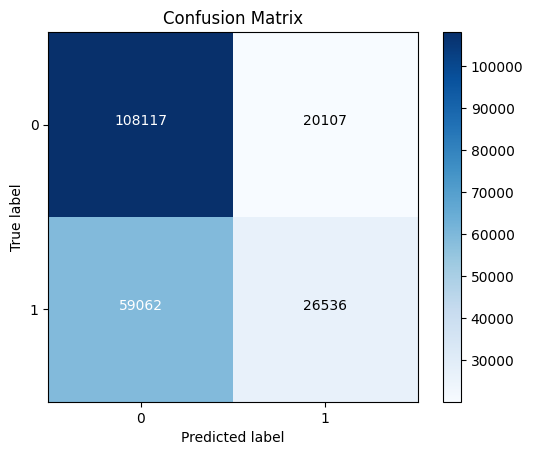

In [48]:

# Plot the confusion matrix
plt.figure()
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'), horizontalalignment="center", color="white" if cnf_matrix[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Accuracy

In [49]:
print(evaluator.evaluate(test_results))


0.6276458352999773
